# Estimation of flight delays

### Data exploration

#### Loading dataset

In [43]:
import pandas as pd

data = pd.read_csv('data/dataset_SCL.csv',parse_dates=['Fecha-I','Fecha-O'])

print('Size of the dataset N:',data.shape[0])

print('Features ('+str(data.shape[1])+'): ' + ', '.join(data.columns))

Size of the dataset N: 68206
Features (18): Fecha-I, Vlo-I, Ori-I, Des-I, Emp-I, Fecha-O, Vlo-O, Ori-O, Des-O, Emp-O, DIA, MES, AÑO, DIANOM, TIPOVUELO, OPERA, SIGLAORI, SIGLADES


In [2]:
import numpy as np

compareData = ['Vlo', 'Ori', 'Des']

for comp in compareData:
    comparison = data[comp+'-I'] != data[comp+'-O']

    if comparison.any():
        print(comp+' differs '+str(sum(comparison))+' times, at:')
        print(np.where(comparison))
    else:
        print(comp+' do not differ')

Vlo differs 1850 times, at:
(array([ 6018,  6020,  6022, ..., 65534, 65535, 68068]),)
Ori do not differ
Des differs 28 times, at:
(array([ 1397,  7290,  7520,  8456, 12787, 12823, 16169, 16937, 18293,
       20444, 24569, 25419, 25422, 25492, 33166, 37162, 38094, 38135,
       38136, 39265, 42112, 55144, 61463, 62651, 67599, 67600, 67601,
       67697]),)


#### Plotting data

Following plots show distributions of a subset of the data.

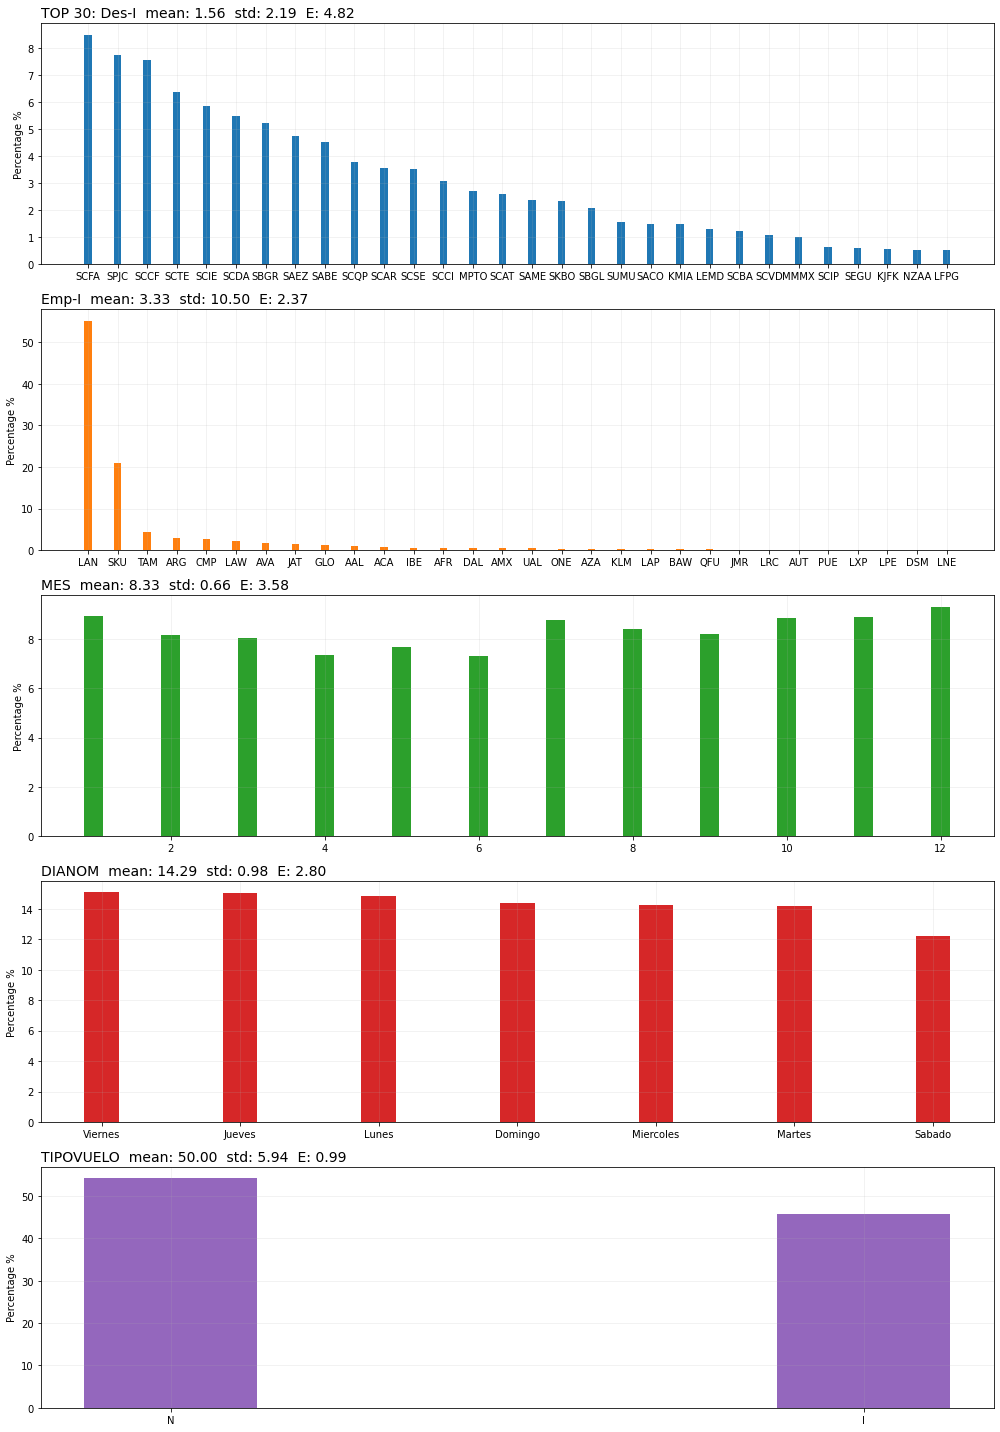

In [27]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

toShow = ['Des-I', 'Emp-I', 'MES', 'DIANOM', 'TIPOVUELO']
nPlots = len(toShow)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(nPlots,1,figsize=(14,4*nPlots))

total = data.shape[0]
usePercentage = True

for col,ax,color in zip(toShow,axs,colors):
    vCounts = data[col].value_counts()
    cat = vCounts.index
    count = 100.0*vCounts.values/total if usePercentage else vCounts.values
    m,s = [np.mean(count),np.std(count,ddof=1)]
    E = entropy(vCounts.values/total, base=2)
    # sem = s/np.sqrt(total)
    title = col+'  mean: '+f'{m:.2f}'+'  std: '+f'{s:.2f}'+'  E: '+f'{E:.2f}'
    if len(cat)>30:
        cat = cat[:30]
        count = count[:30]
        title = 'TOP 30: '+title
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(title,fontsize=14,loc='left')
    ax.set_ylabel('Percentage %' if usePercentage else 'Counts #')
    ax.grid(alpha=0.2)

plt.tight_layout()

From the data, it can be extracted that:
  - Destinations are widely varied, being a potentially informative variable (it has the greatest entropy).
  - LAN managed more than 50% of the flights. 
  - Data from MES, DIANOM, and TIPOVUELO have a more flat distributions, meaning that they can also be informative.

#### Creating synthetic features

In [68]:
from datetime import date as dt
from datetime import time as tm

highSeasons = [[dt(2016,12,15),dt(2017,3,3)],
               [dt(2017,7,15),dt(2017,7,31)],
               [dt(2017,9,11),dt(2017,9,30)],
               [dt(2017,12,15),dt(2018,3,3)]]


newFeatures = {'temporada_alta': np.full((total,),False)}
for hS in highSeasons:
    fI = data['Fecha-I'].dt.date
    newFeatures['temporada_alta'] |= ((fI >= hS[0]) & (fI <= hS[1]))

newFeatures['dif_min'] = (data['Fecha-O']-data['Fecha-I'])/pd.Timedelta(minutes=1)
newFeatures['atraso_15'] = newFeatures['dif_min'] > 15

hours = data['Fecha-I'].dt.hour
newFeatures['periodo_dia'] = np.full((total,),'      ')
newFeatures['periodo_dia'][(hours >=5) & (hours < 12)] = 'mañana'
newFeatures['periodo_dia'][(hours >=12) & (hours < 19)] = 'tarde'
newFeatures['periodo_dia'][(hours >=19) | (hours < 5)] = 'noche'

newFeatures = pd.DataFrame.from_dict(newFeatures)
newFeatures['temporada_alta'] = newFeatures['temporada_alta'].astype(int)
newFeatures['atraso_15'] = newFeatures['atraso_15'].astype(int)
newFeatures.to_csv('synthetic_features.csv')